# MazeDrone with TF Agents

### Setup

In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

2024-06-14 20:15:02.741653: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 20:15:02.746847: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 20:15:02.827481: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 20:15:04.350591: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameters

In [3]:
num_iterations = 20_000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
#replay_buffer_max_length = 100000  # @param {type:"integer"}
replay_buffer_max_length = 100  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

### Environment

In [4]:
# Some necessary imports 
import sys
#sys.path.append('/home/naski/Documents/dev/maze_drone_v02/maze-drone-v02/lib/python3.10/site-packages')
import gym
import gym_maze


In [5]:
# Importing custom environment
env_name = 'maze-v0'
env = suite_gym.load(env_name)

# Testing
env.reset()

TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([0.       , 1.       , 0.       , 1.       , 1.4142135],
      dtype=float32)})

Usually two environments are instantiated: one for training and one for evaluation.

In [6]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### Agent

In [7]:
fc_layer_params = (200, 100, 50, ) # fc = fully connected
#fc_layer_params = (100, 10, 10, )

action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))
# O uso do inicializador VarianceScaling com mode='fan_in' e 
# distribution='truncated_normal' no seu código é uma estratégia para manter
# a variância dos sinais aproximadamente constante nas camadas densas da rede.
# Crucial para garantir um treinamento eficiente e evitar problemas como o 
# vanishing gradient (gradiente evanescente) e o exploding gradient 
# (gradiente explosivo).

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

### Policies


In [9]:
# The main policy that is used for evaluation and deployment.
eval_policy = agent.policy
# A second policy that is used for data collection.
collect_policy = agent.collect_policy

### Metrics and Evaluation

In [10]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

### New Observer

In [11]:
from tf_agents.metrics import py_metric

class MyMetric(py_metric.PyMetric):

    def __init__(self, name="MyMetric"):
        super(MyMetric, self).__init__(name=name)
        self._count = 0

    def call(self, trajectory):
        if trajectory.reward.numpy()[0] == -51.:
            self._count += 1

    def result(self):
        return self._count
    
    def reset(self):
        self._count = 0

# Create an instance of MyMetric
my_metric = MyMetric()

### Replay Buffer

In [12]:
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

In [13]:
replay_buffer_capacity = replay_buffer_max_length

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

num_episodes = tf_metrics.NumberOfEpisodes()
env_steps = tf_metrics.EnvironmentSteps()

# Add an observer that adds to the replay buffer:
replay_observer = [replay_buffer.add_batch, num_episodes, env_steps, my_metric]

### Data Collection

In [14]:
# Data collection:
collect_op = dynamic_step_driver.DynamicStepDriver(
  train_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration).run()

In [15]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


### Training the Agent

In [16]:
%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=replay_observer,
    num_steps=collect_steps_per_iteration)

iterator = iter(dataset)

loss_log = []
step_log = []
steps_per_episode_log = []
episodes_per_log_interval = []
previous_n_episodes = 0

my_metric_log = []

avg_steps_per_episode_per_eval_interval = []

for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run()

    # Sample a batch of data from the buffer and update the agent's network.
    trajectories, _ = next(iterator)
    train_loss = agent.train(experience=trajectories).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        #print('step = {0}: loss = {1}'.format(step, train_loss))
        step_log.append(step)
        loss_log.append(train_loss)
        episodes_per_log_interval.append(num_episodes.result().numpy() - previous_n_episodes)
        steps_per_episode_log.append(log_interval / (episodes_per_log_interval[-1]))
        previous_n_episodes = num_episodes.result().numpy()

    if step % eval_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        avg_steps_per_episode_per_eval_interval.append(eval_interval / sum(episodes_per_log_interval[-10:]))
        print('Avg of Steps/Episode: {:.2f}'.format(avg_steps_per_episode_per_eval_interval[-1]) )

        current_value = my_metric.result()
        my_metric_log.append(current_value)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1000: loss = 29771.345703125
step = 1000: Average Return = -2225.0
Avg of Steps/Episode: 43.48
step = 2000: loss = 14890.98828125
step = 2000: Average Return = -2245.0
Avg of Steps/Episode: 22.22
step = 3000: loss = 4411.2958984375
step = 3000: Average Return = -2510.0
Avg of Steps/Episode: 21.28
step = 4000: loss = 8224.9208984375
step = 4000: Average Return = -2240.0
Avg of Steps/Episode: 20.41
step = 5000: loss = 5939.8349609375
step = 5000: Average Return = -2510.0
Avg of Steps/Episode: 20.00
step = 6000: loss = 27399.904296875
step = 6000: Average Return = -1965.0999755859375
Avg of Steps/Episode: 19.61
step = 7000: loss = 68859.484375
step = 7000: Average Return = -1665.199951171875
Avg of Steps/Episode: 20.83
step = 8000: loss = 2314.25
step 

## Visualization

In [17]:
import pandas as pd

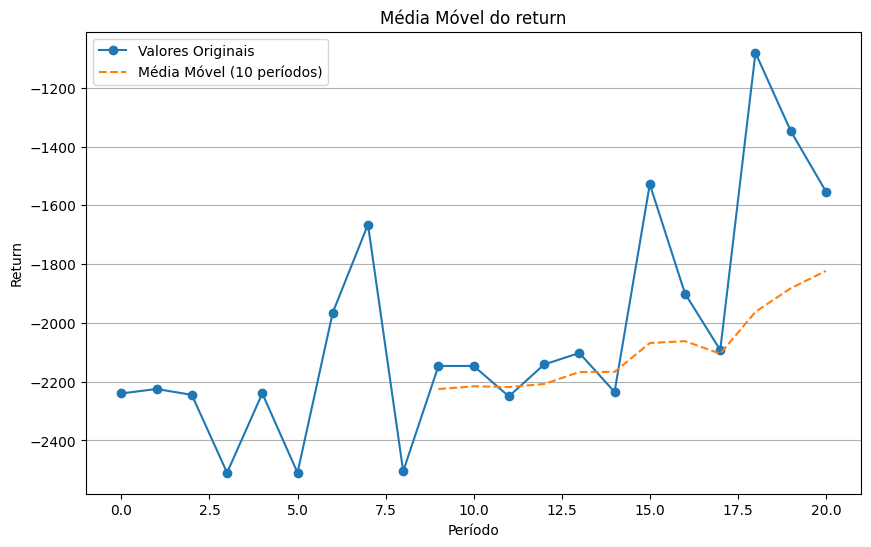

In [19]:
# Loss - média móvel
# Ela serve para suavizar as flutuações de curto prazo em um conjunto de dados, 
# revelando a tendência subjacente e facilitando a identificação de pontos de reversão.
return_df = pd.DataFrame({'return': returns}) 

periodo_media_movel = 10
return_df['media_movel'] = return_df['return'].rolling(window=periodo_media_movel).mean()

plt.figure(figsize=(10, 6))
plt.plot(return_df['return'], label='Valores Originais', marker='o')
plt.plot(return_df['media_movel'], label=f'Média Móvel ({periodo_media_movel} períodos)', linestyle='dashed')
plt.xlabel('Período')
plt.ylabel('Return')
plt.title('Média Móvel do return')
plt.legend()
plt.grid(axis='y')
#plt.ylim(top=100, bottom=-50)
plt.show()

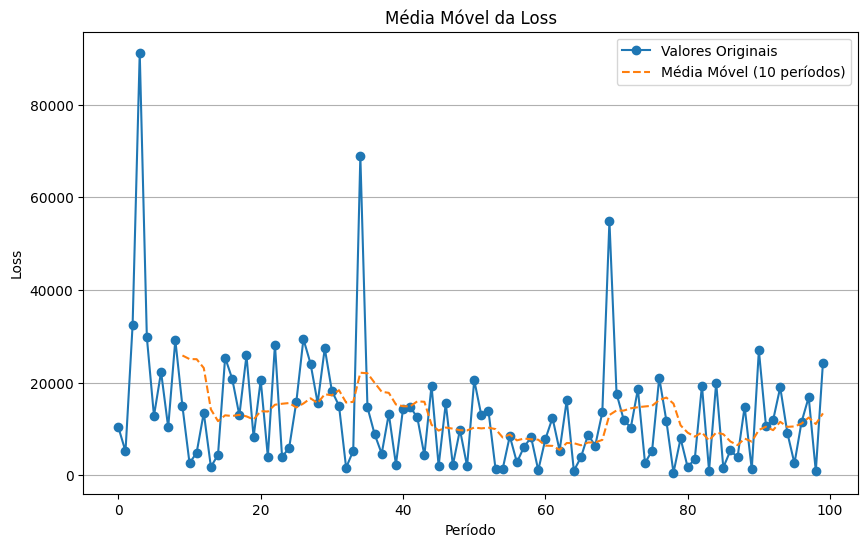

In [21]:
# Loss - média móvel
# Ela serve para suavizar as flutuações de curto prazo em um conjunto de dados, 
# revelando a tendência subjacente e facilitando a identificação de pontos de reversão.
loss_df = pd.DataFrame({'loss': loss_log}) 

periodo_media_movel = 10
loss_df['media_movel'] = loss_df['loss'].rolling(window=periodo_media_movel).mean()

plt.figure(figsize=(10, 6))
plt.plot(loss_df['loss'], label='Valores Originais', marker='o')
plt.plot(loss_df['media_movel'], label=f'Média Móvel ({periodo_media_movel} períodos)', linestyle='dashed')
plt.xlabel('Período')
plt.ylabel('Loss')
plt.title('Média Móvel da Loss')
plt.legend()
plt.grid(axis='y')
#plt.ylim(top=5000, bottom=0)
plt.show()

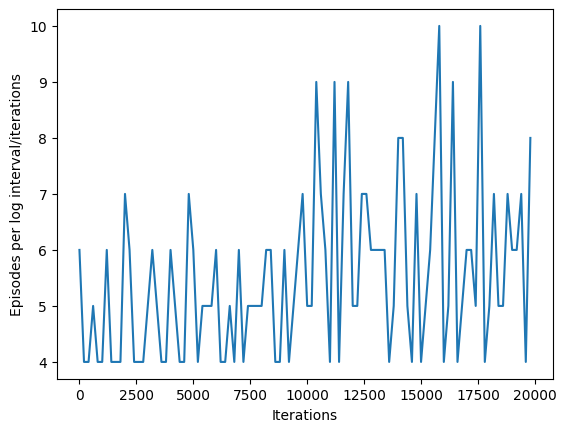

In [22]:
iterations = range(0, num_iterations, log_interval)
plt.plot(iterations, episodes_per_log_interval)
plt.ylabel('Episodes per log interval/iterations') 
plt.xlabel('Iterations')
#plt.ylim(top=50)
plt.show()

Text(0.5, 0, 'Iterations')

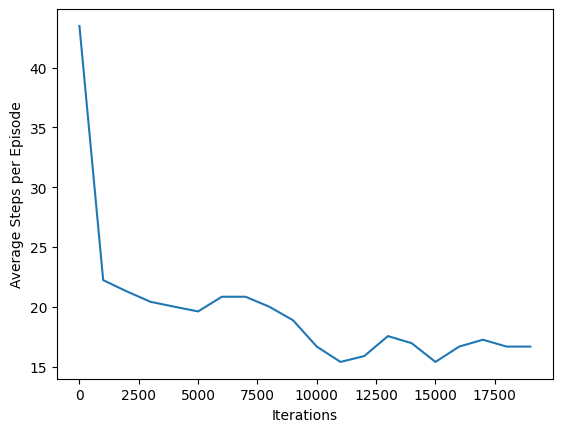

In [23]:
iterations = range(0, num_iterations, eval_interval)
plt.plot(iterations, avg_steps_per_episode_per_eval_interval)
plt.ylabel('Average Steps per Episode') 
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

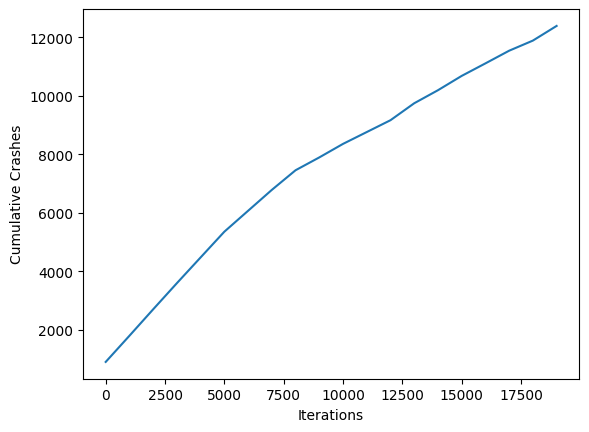

In [24]:
iterations = range(0, num_iterations, eval_interval)
plt.plot(iterations, my_metric_log)
plt.ylabel('Cumulative Crashes') 
plt.xlabel('Iterations')

In [25]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [26]:
def create_policy_eval_video(policy, filename, num_episodes=10, fps=24):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, "trained-agent")

### Keep Training 